In [2]:
import os

import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import confusion_matrix
# import seaborn as sns
from datetime import datetime
import imageio
from skimage import img_as_ubyte

import pprint
# import the necessary packages
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv3D, Conv2D, Conv1D, Convolution2D, Deconvolution2D, Cropping2D, UpSampling2D
from keras.layers import Input, Conv2DTranspose, ConvLSTM2D, TimeDistributed, Embedding
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers import Concatenate, concatenate, Reshape, multiply, ZeroPadding2D
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam, SGD
from keras.models import Model
from keras.callbacks import TensorBoard
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.layers import Input, merge
from keras.regularizers import l2
from keras.layers import Input, merge, Convolution2D, MaxPooling2D, AveragePooling2D, UpSampling2D, Reshape, core, Dropout, LeakyReLU
import keras.backend as kb


ModuleNotFoundError: No module named 'utilsGAN'

In [1]:

class GANModel():
    def __init__(self, batch_size=32, inputShape=(128, 128, 3), dropout_prob=0.25): 
        self.batch_size = batch_size
        self.inputShape = inputShape
        self.dropout_prob = dropout_prob
        
        self.gf = 64
        self.df = 64
        
  
        #discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5),metrics=['accuracy'])
 
        #generator
        self.generator = self.build_generator()

        # Input images and their conditioning images
        first_frame = Input(shape=self.inputShape)
        last_frame = Input(shape=self.inputShape)

        # By conditioning on the first frame generate a fake version of the last frame
        fake_last_frame = self.generator(first_frame)

        # Only train the generator
        self.discriminator.trainable = False
        
        valid = self.discriminator([fake_last_frame, first_frame])

        self.combined = Model(inputs=[last_frame, first_frame], outputs=[valid, fake_last_frame])
        self.combined.compile(loss='binary_crossentropy',
                              optimizer=Adam(0.0002, 0.5))


    def build_generator(self):
        inputs = Input(shape=self.inputShape)
        momentum_rate = 0.8
        
        
        def conv2d(layer_input, filters, f_size=3, bn=False, double=False,dropout_rate=0 ):
            d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
            
            if bn:
                d = BatchNormalization(momentum=0.8)(d)
            d = LeakyReLU(alpha=0.2)(d)
            if dropout_rate:
                d = Dropout(dropout_rate)(d)
            if double:
                d = Conv2D(filters, kernel_size=f_size,strides=1, padding='same')(d)
                d = LeakyReLU(alpha=0.2)(d)
            return d


        def deconv2d(layer_input, skip_input, n_filters, f_size=3, dropout_rate=0, double=False,bn=True):
            u = Conv2DTranspose(n_filters,kernel_size=3, strides=2, padding='same')(layer_input)
            u = Concatenate()([u, skip_input])
            u = BatchNormalization(momentum=0.8)(u)
            
            if dropout_rate:
                u = Dropout(dropout_rate)(u)
            u = LeakyReLU(alpha=0.2)(u)
                        
            if double:
                u = Conv2D(n_filters, kernel_size=f_size,strides=1, padding='same')(u)
                u = LeakyReLU(alpha=0.2)(u)
            return u
        
        
        start = Conv2D(self.gf, 3, padding='same')(inputs)
        start = LeakyReLU(alpha=0.2)(start)
        d1 = conv2d(start, self.gf*2)#64
        d2 = conv2d(d1, self.gf*4,bn=True, dropout_rate=0.5)
        d3 = conv2d(d2, self.gf*8,)
        d4 = conv2d(d3, self.gf*8,bn=True, dropout_rate=0.5)
        d5 = conv2d(d4, self.gf*8)
        d6 = conv2d(d5, self.gf*8)
        u2 = deconv2d(d6, d5, self.gf*8, bn=False)
        u3 = deconv2d(u2, d4, self.gf*8)
        u4 = deconv2d(u3, d3, self.gf*8)
        u5 = deconv2d(u4, d2, self.gf*4)
        u6 = deconv2d(u5, d1, self.gf*2)
        u8= deconv2d(u6, start, self.gf)
        
        nbr_img_channels = 3
        classify = Conv2D(nbr_img_channels, (1, 1), activation='sigmoid')(u8)
        
        model = Model(inputs=inputs, outputs=classify, name='Generator')
        model.summary()


        return model

    def build_discriminator(self):
        last_img = Input(shape=self.inputShape)
        first_img = Input(shape=self.inputShape)
        alpha=0.2

        # Concatenate image and conditioning image by channels to produce input
        combined_imgs = Concatenate(axis=-1)([last_img, first_img])

        d2 = Conv2D(self.df, 3, strides=2, padding='same')(combined_imgs) 
        d2 = LeakyReLU(alpha=alpha)(d2)
        d2 = Dropout(0.5)(d2)
        
        d2 = Conv2D(self.df*2, 3, strides=2, padding='same')(d2)
        d2 = LeakyReLU(alpha=alpha)(d2)
        d2 = Dropout(0.5)(d2)
  
        d2 = Conv2D(self.df*4, 3, strides=2, padding='same')(d2)
        d2 = LeakyReLU(alpha=alpha)(d2)

               
        validity = Conv2D(1, (3, 3), strides=2, padding='same', activation='tanh')(d2)
        

        model = Model([last_img, first_img], validity)
        model.summary()

        return model
        


In [2]:
image_shape = (cfg.IMAGE_HEIGHT, cfg.IMAGE_WIDTH, cfg.IMAGE_CHANNEL)
modelObj = GANModel(batch_size=cfg.BATCH_SIZE, inputShape=image_shape, dropout_prob=cfg.DROPOUT_PROB)


NameError: name 'cfg' is not defined

In [128]:
start_time = datetime.now()
# Adversarial loss ground truths
valid = np.ones((cfg.BATCH_SIZE,) + modelObj.disc_patch)
fake = np.zeros((cfg.BATCH_SIZE,) + modelObj.disc_patch)
# log file
output_log_dir = "./logs/{}".format(datetime.now().strftime("%Y%m%d-%H%M%S"))
if not os.path.exists(output_log_dir):
    os.makedirs(output_log_dir)

In [129]:
import imageio
import matplotlib.pyplot as plt
from skimage import img_as_ubyte
import numpy as np 

%matplotlib inline
epochs = 3#cfg.NUM_EPOCHS

test_first_imgs, test_last_imgs = next(test_batch_generator)
steps_per_epoch = (nbr_train_data // cfg.BATCH_SIZE) 
print(steps_per_epoch)
g_loss_plot = np.zeros((steps_per_epoch,epochs))
d_loss_plot = np.zeros((steps_per_epoch,epochs))

for epoch in range(epochs):
    
    for batch_i in range(steps_per_epoch):
        first_frames, last_frames= next(train_batch_generator)
        if first_frames.shape[0] == cfg.BATCH_SIZE: 
             
            fake_last_frames = modelObj.generator.predict(first_frames)

            d_loss_real = modelObj.discriminator.train_on_batch([last_frames, first_frames], valid)
            d_loss_fake = modelObj.discriminator.train_on_batch([fake_last_frames, first_frames], fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
            d_loss_plot[batch_i,epoch] = d_loss[0]
            
            # Train the generator
            g_loss = modelObj.combined.train_on_batch([last_frames, first_frames], [valid, last_frames])
            g_loss_plot[batch_i,epoch] = g_loss[0]
            elapsed_time = datetime.now() - start_time 
            print ("[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f] time: %s" % (epoch, epochs,
                                                                                               batch_i,
                                                                                               steps_per_epoch,
                                                                                               d_loss[0], 
                                                                                               g_loss[0],
                                                                                               elapsed_time))
            # run some tests to check how the generated images evolve during training
            test_fake_last_imgs = modelObj.generator.predict(test_first_imgs)
            test_img_name = output_log_dir + "/gen_img_epoc_" + str(epoch) + ".png"
            merged_img = np.vstack((first_frames[0],last_frames[0],fake_last_frames[0]))
            imageio.imwrite(test_img_name, img_as_ubyte(merged_img)) #scipy.misc.imsave(test_img_name, merged_img)
  

216
(50, 128, 128, 3)
0.5046887
[Epoch 0/3] [Batch 0/216] [D loss: 0.503479] [G loss: 51.701847] time: 0:00:02.623190
(50, 128, 128, 3)
0.50784343
[Epoch 0/3] [Batch 1/216] [D loss: 0.320332] [G loss: 46.896183] time: 0:00:03.195715
(50, 128, 128, 3)
0.5165524
[Epoch 0/3] [Batch 2/216] [D loss: 0.281362] [G loss: 42.864548] time: 0:00:03.790115
(50, 128, 128, 3)
0.52651864
[Epoch 0/3] [Batch 3/216] [D loss: 0.276795] [G loss: 40.628166] time: 0:00:04.365665
(50, 128, 128, 3)
0.54154927
[Epoch 0/3] [Batch 4/216] [D loss: 0.270919] [G loss: 37.380886] time: 0:00:04.925701
(50, 128, 128, 3)
0.55348235
[Epoch 0/3] [Batch 5/216] [D loss: 0.268467] [G loss: 36.999401] time: 0:00:05.497708
(50, 128, 128, 3)
0.56945187
[Epoch 0/3] [Batch 6/216] [D loss: 0.269541] [G loss: 35.645245] time: 0:00:06.061457
(50, 128, 128, 3)
0.5856711
[Epoch 0/3] [Batch 7/216] [D loss: 0.270742] [G loss: 33.758957] time: 0:00:06.632250
(50, 128, 128, 3)
0.59759766
[Epoch 0/3] [Batch 8/216] [D loss: 0.267095] [G lo

In [130]:
#Generate images

for batch_i in range(100):
    test_first_imgs, test_last_imgs = next(test_batch_generator)
    test_fake_last_imgs = modelObj.generator.predict(test_first_imgs) 
    test_img_name = output_log_dir + "/gen_img_test_" + str(batch_i) + ".png"
    merged_img = np.vstack((test_first_imgs[0],test_last_imgs[0],test_fake_last_imgs[0]))
    imageio.imwrite(test_img_name, img_as_ubyte(merged_img))

In [16]:
##g_loss_plot
print(g_loss)
steps=216
num_of_epochs = 3
g_loss_vector_plot = np.zeros(steps*num_of_epochs)
d_loss_vector_plot = np.zeros(steps*num_of_epochs)
#print(d_loss_plot)
for i in range(num_of_epochs):
    for k in range(steps):
        g_loss_vector_plot[k+i*steps] = g_loss_plot[k,i]
        d_loss_vector_plot[k+i*steps] = d_loss_plot[k,i]


[2.6418356895446777, 0.2725187838077545, 0.02369316853582859]


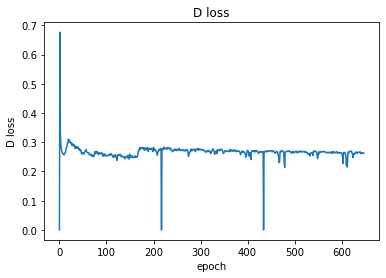

In [17]:

plt.plot(d_loss_vector_plot)
plt.title('D loss')
plt.ylabel('D loss')
plt.xlabel('epoch')
plt.show()

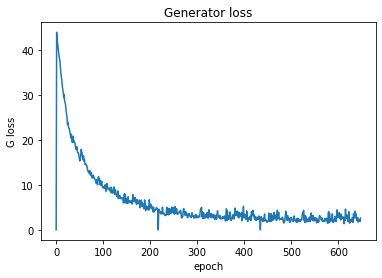

In [18]:
plt.plot(g_loss_vector_plot)
plt.title('Generator loss')
plt.ylabel('G loss')
plt.xlabel('epoch')
plt.show()